In [1]:
from Classification_library import  *
from Prediction_tool import  * 
from tqdm import tqdm
import os 
import pandas as pd
import pydicom
from pydicom.data import get_testdata_file
import matplotlib.pyplot as plt
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from Prediction_tool import  * 

In [3]:
# изменим подход   disease

# составим датасет из полученных png изображений для нормы label norma, пневмонии pneumonia и пневмоторакса pneumotorax

data = []
for img_path in os.listdir('norma_lung'):
    data.append((f'norma_lung/{img_path}', 'norma'))
for img_path in os.listdir('pneumonia_lung'):
    data.append((f'pneumonia_lung/{img_path}', 'pneumonia'))
for img_path in os.listdir('pneumotorax_lung'):
    data.append((f'pneumotorax_lung/{img_path}', 'pneumotorax'))
df = pd.DataFrame(data, columns=['image_path', 'label'])
print(df['label'].value_counts())

label
pneumotorax    458
norma          374
pneumonia      367
Name: count, dtype: int64


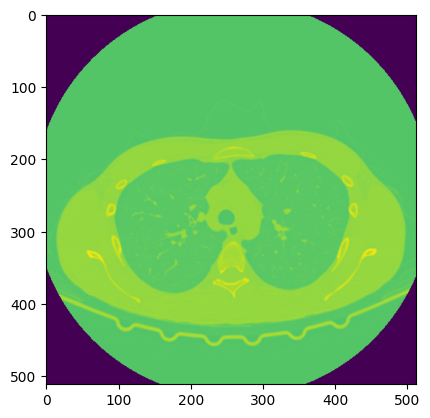

In [4]:
img_path = "pneumonia_png/100003A0_anon.png"
img = Image.open(img_path)
# переведемв серый 
img = img.convert('L')
img = np.array(img)
# покажем изображение
plt.imshow(img)

In [5]:
from PIL import Image
import numpy as np

# Открываем изображение
img_path = "pneumonia_png/100003A0_anon.png"
image = Image.open(img_path)

# Базовые характеристики
print("Формат:", image.format)
print("Режим:", image.mode)  # e.g., RGB, L (grayscale), P (палитра)
print("Размер (ширина, высота):", image.size)

# Преобразуем в numpy-массив
img_array = np.array(image)
print("Размерность массива:", img_array.shape)

# Определяем количество уникальных цветов
if len(img_array.shape) == 3:  # Цветное изображение (H, W, C)
    unique_colors = np.unique(img_array.reshape(-1, img_array.shape[2]), axis=0)
    print("Количество уникальных цветов:", len(unique_colors))
else:  # Оттенки серого (H, W)
    print("Количество уникальных цветов (оттенков):", len(np.unique(img_array)))

# Дополнительно: размер массива в памяти
print("Размер массива (в элементах):", img_array.size)
print("Тип данных массива:", img_array.dtype)

Формат: PNG
Режим: L
Размер (ширина, высота): (512, 512)
Размерность массива: (512, 512)
Количество уникальных цветов (оттенков): 74
Размер массива (в элементах): 262144
Тип данных массива: uint8


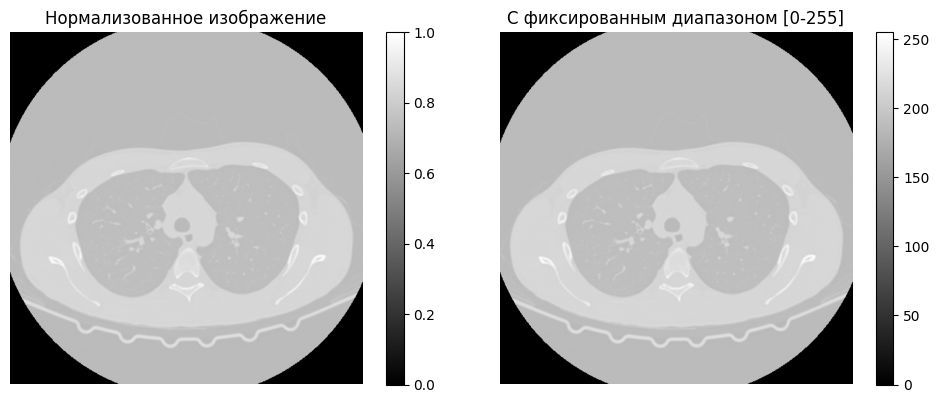

In [6]:
# Нормализация для лучшей визуализации (если нужно)
if img_array.max() > 0:
    img_normalized = (img_array - img_array.min()) / (img_array.max() - img_array.min())
else:
    img_normalized = img_array

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_normalized, cmap='gray')
plt.colorbar()
plt.title('Нормализованное изображение')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_array, cmap='gray', vmin=0, vmax=255)
plt.colorbar()
plt.title('С фиксированным диапазоном [0-255]')
plt.axis('off')

plt.tight_layout()
plt.show()

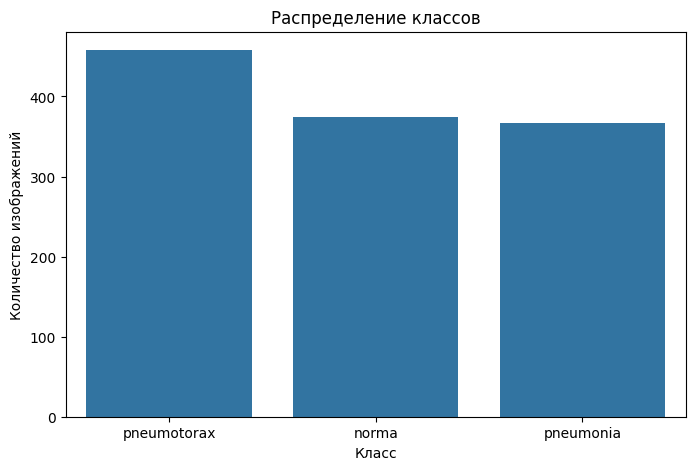

In [7]:
#построим диаграмму распределения классов
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Количество изображений')
plt.show()

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Используемое устройство: {device}') 

BATCH_SIZE = 64
NUM_EPOCHS = 40
NUM_WORKERS = 16

Используемое устройство: cuda


In [9]:
df

,image_path,label
0,norma_lung/10000EEE_anon.png,norma
1,norma_lung/10000FD7_anon.png,norma
2,norma_lung/10000FB7_anon.png,norma
3,norma_lung/10000F9C_anon.png,norma
4,norma_lung/10000EA8_anon.png,norma
...,...,...
1194,pneumotorax_lung/frame_149.png,pneumotorax
1195,pneumotorax_lung/frame_212.png,pneumotorax
1196,pneumotorax_lung/frame_054.png,pneumotorax
1197,pneumotorax_lung/frame_272.png,pneumotorax


In [ ]:
from Classification_library import Learning_rocks, TrainConfig
from sklearn.preprocessing import LabelEncoder
import numpy as np

# подготовка данных
df2 = df.rename(columns={'image_path':'path'}).copy()


le = LabelEncoder()
df2['label'] = le.fit_transform(df2['label'])


In [11]:
# перемешаем df2
df2 = df2.sample(frac=1, random_state=42).reset_index(drop=True)
df2.head()

,path,label
0,pneumotorax_lung/frame_395.png,2
1,pneumotorax_lung/frame_189.png,2
2,norma_lung/10000F80_anon.png,0
3,pneumonia_lung/10000332_anon.png,1
4,norma_lung/10000F3D_anon.png,0


In [12]:
# разделим на train/test (80/20)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df2, test_size=0.2, stratify=df2['label'], random_state=42)
print("Train/Test sizes:", len(train_df), len(test_df))

Train/Test sizes: 959 240


In [13]:

# нормированные веса классов (опционально)
vc = train_df['label'].value_counts().sort_index().to_numpy()
w = (vc.sum() / vc).astype(np.float32)
w = (w / w.mean()).tolist()

# КОНФИГ ДЛЯ "ПЕРВОГО ВАРИАНТА" БИБЛИОТЕКИ
cfg = TrainConfig(
    num_classes = train_df['label'].nunique(),
    in_channels = 1,
    image_size  = 512,
    backbone    = 'tiny_cnn',
    batch_size  = 16,
    num_workers = 0,       # WSL → 0–2
    lr          = 5e-4,    # мягче
    weight_decay= 1e-4,
    num_epochs  = 30,
    early_stop_patience = 6,
    focal_gamma = 1.0,     # не влияет при CE, пусть остаётся
    class_weights = w,     # как у тебя
    val_split   = 0.2,
    seed        = 42,
    rotate_deg  = 2        # помягче
)


trainer = Learning_rocks(
    train_df=train_df,
    config=cfg,
    label_col='label',
    path_col='path',
    image_col='image'
)

trainer.learn_model()
trainer.save_checkpoint("models/best_model.pth")

# Явная проверка на None
val_size = len(trainer.val_df) if trainer.val_df is not None else 0
print("Train/Val sizes:", len(trainer.train_df), val_size)

[Device] cuda
Epoch 1/30 | TrainLoss: 0.1663 | ValLoss: 1.1451
Epoch 2/30 | TrainLoss: 0.0502 | ValLoss: 3.0508
Epoch 3/30 | TrainLoss: 0.0235 | ValLoss: 3.7454
Epoch 4/30 | TrainLoss: 0.0078 | ValLoss: 0.0137
Epoch 5/30 | TrainLoss: 0.0098 | ValLoss: 2.3504
Epoch 6/30 | TrainLoss: 0.0354 | ValLoss: 1.0804
Epoch 7/30 | TrainLoss: 0.0214 | ValLoss: 2.2885
Epoch 8/30 | TrainLoss: 0.0222 | ValLoss: 1.8070
Epoch 9/30 | TrainLoss: 0.0043 | ValLoss: 3.9054
Epoch 10/30 | TrainLoss: 0.0015 | ValLoss: 0.0012
Epoch 11/30 | TrainLoss: 0.0005 | ValLoss: 0.0258
Epoch 12/30 | TrainLoss: 0.0003 | ValLoss: 0.0000
Epoch 13/30 | TrainLoss: 0.0002 | ValLoss: 0.0000
Epoch 14/30 | TrainLoss: 0.0001 | ValLoss: 0.0000
Epoch 15/30 | TrainLoss: 0.0001 | ValLoss: 0.0000
Epoch 16/30 | TrainLoss: 0.0002 | ValLoss: 0.0000
Epoch 17/30 | TrainLoss: 0.0031 | ValLoss: 0.0003
Epoch 18/30 | TrainLoss: 0.0092 | ValLoss: 0.0006
Epoch 19/30 | TrainLoss: 0.0004 | ValLoss: 0.0017
Epoch 20/30 | TrainLoss: 0.0010 | ValLoss: 0.

In [14]:
le.classes_

array(['norma', 'pneumonia', 'pneumotorax'], dtype=object)

In [17]:
import pickle
with open('models/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

Using device: cuda
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
[DEBUG] arch=tiny_cnn, in_channels=1, num_classes=3, image_size=512, mode=L
Accuracy: 1.0
F1 macro: 1.0

Classification report:
               precision    recall  f1-score   support

       norma       1.00      1.00      1.00        75
   pneumonia       1.00      1.00      1.00        73
 pneumotorax       1.00      1.00      1.00        92

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240

Confusion matrix:
 [[75  0  0]
 [ 0 73  0]
 [ 0  0 92]]

ROC-AUC micro: 1.0000 | macro: 1.0000


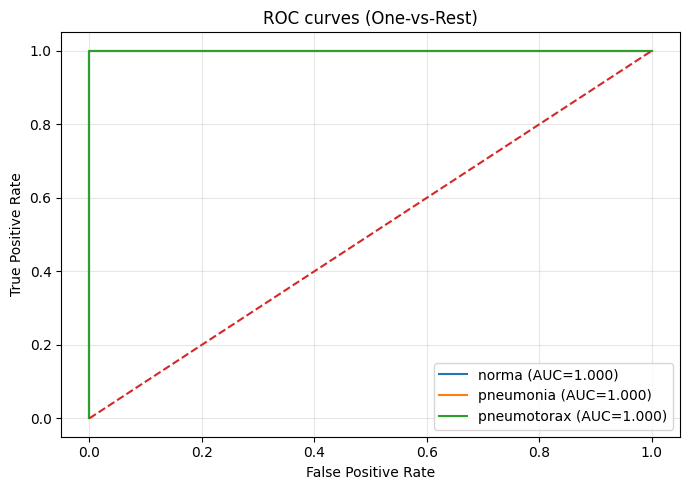

In [18]:
# ==== Evaluation on test_df: metrics + ROC-AUC ====
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# 1) Загрузим LabelEncoder (имена классов)
with open('models/label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)
class_names = le.classes_.tolist()
num_classes = len(class_names)

# 2) Предиктор (совместим с TinyCNN/CustomNet и серым 512)
from Prediction_tool import Predict

pred = Predict(
    num_classes=num_classes,           # будет проверка и при необходимости скорректирует по чекпоинту
    device='auto',
    model_path='models/best_model.pth',
    class_names=class_names
)

# 3) Получим вероятности на тесте (поддерживает и paths, и память-изображения)
#    Ожидается test_df со столбцами: 'path' (или 'image') и 'label'
BATCH = 64

def iter_batches(lst, bs):
    for i in range(0, len(lst), bs):
        yield lst[i:i+bs]

# если есть столбец 'path', используем его; иначе предполагаем 'image'
input_col = 'path' if 'path' in test_df.columns else 'image'
y_true = test_df['label'].to_numpy()

probs_list = []
for chunk in iter_batches(test_df[input_col].tolist(), BATCH):
    out = pred.predict_batch(chunk)  # список словарей
    probs_list.append(np.vstack([o['probabilities'] for o in out]))
probs = np.vstack(probs_list)            # [N, C]
y_pred = probs.argmax(axis=1)

# 4) Классические метрики
acc  = accuracy_score(y_true, y_pred)
f1m  = f1_score(y_true, y_pred, average='macro')
cm   = confusion_matrix(y_true, y_pred)
print("Accuracy:", acc)
print("F1 macro:", f1m)
print("\nClassification report:\n", classification_report(y_true, y_pred, target_names=class_names))
print("Confusion matrix:\n", cm)

# 5) ROC-AUC (OvR) + кривые
#    Для ROC-AUC OvR нужны бинарные индикаторы по классам
y_true_bin = np.zeros((len(y_true), num_classes), dtype=int)
y_true_bin[np.arange(len(y_true)), y_true] = 1

# micro/macro
auc_micro = roc_auc_score(y_true_bin, probs, average='micro', multi_class='ovr')
auc_macro = roc_auc_score(y_true_bin, probs, average='macro', multi_class='ovr')
print(f"\nROC-AUC micro: {auc_micro:.4f} | macro: {auc_macro:.4f}")

# По каждому классу построим кривые
plt.figure(figsize=(7,5))
for c in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, c], probs[:, c])
    plt.plot(fpr, tpr, label=f"{class_names[c]} (AUC={auc(fpr, tpr):.3f})")
# диагональ
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC curves (One-vs-Rest)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 6) (опционально) метрики по train/val, если они у тебя под рукой как dataframes:
# from Classification_library import Learning_rocks, TrainConfig
# cfg = TrainConfig(num_classes=num_classes, in_channels=1, image_size=512, backbone='tiny_cnn', batch_size=16, num_workers=0)
# tr = Learning_rocks(train_df=train_df, config=cfg, label_col='label', path_col='path', image_col='image')
# tr.model.load_state_dict(pred.model.state_dict())   # подхватить лучшие веса
# print("Train eval:", tr.evaluate_df(train_df))
# if 'val_df' in locals() and val_df is not None:
#     print("Val  eval:", tr.evaluate_df(val_df))
